In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

PATH = "test-data/dodgechev/"
sz = 224
arch = resnet34

In [3]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


In [4]:
learn.fit(1e-2, 3)
learn.precompute = False

epoch      trn_loss   val_loss   accuracy                
    0      0.941373   1.348864   0.472222  
    1      0.819945   1.049818   0.472222        
    2      0.717791   0.872071   0.527778        



In [6]:
learn.fit(1e-2, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                
    0      0.524353   0.522343   0.75      
    1      0.461597   0.529408   0.75                    
    2      0.469798   0.528234   0.75                    
    3      0.445218   0.51842    0.777778                
    4      0.432082   0.505565   0.777778                



[array([0.50556]), 0.7777777910232544]

In [7]:
learn.unfreeze()
lr = np.array([1e-4, 1e-3, 1e-2])

In [9]:
learn.fit(lr, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                
    0      0.29719    0.335421   0.833333  
    1      0.281894   0.334573   0.833333                
    2      0.274649   0.334599   0.833333                
    3      0.270072   0.318498   0.833333                
    4      0.254185   0.324735   0.833333                



[array([0.32474]), 0.8333333134651184]

In [10]:
learn.save('dodgechev')

In [11]:
learn.load('dodgechev')

In [19]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

accuracy(probs,y)

TypeError: torch.max received an invalid combination of arguments - got (numpy.ndarray, dim=int), but expected one of:
 * (torch.FloatTensor source)
 * (torch.FloatTensor source, torch.FloatTensor other)
      didn't match because some of the keywords were incorrect: dim
 * (torch.FloatTensor source, int dim)
 * (torch.FloatTensor source, int dim, bool keepdim)


## Analyse

In [14]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[16  1]
 [ 1 18]]


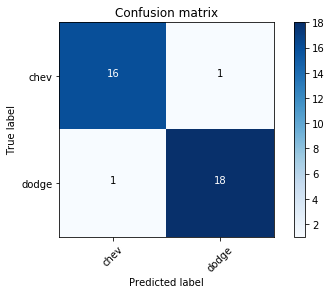

In [15]:
plot_confusion_matrix(cm, data.classes)

In [16]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

Most incorrect dodges


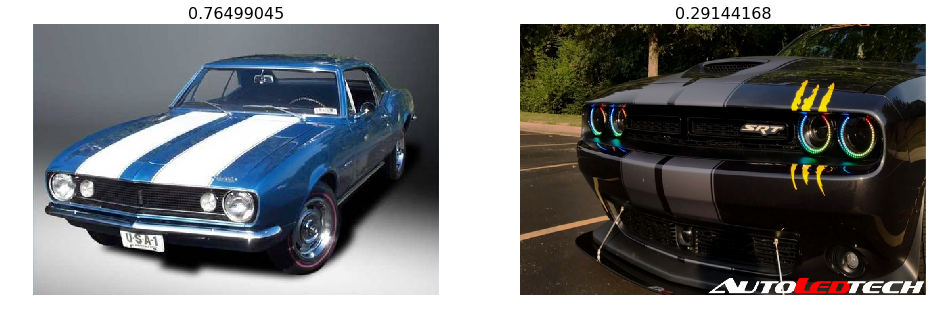

In [17]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect dodges")

Most incorrect chevs


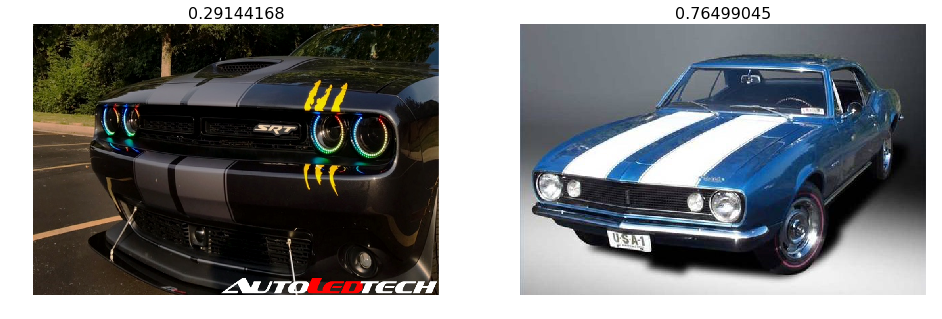

In [18]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect chevs")